## Spatial fidelity testing GEV ##

Spatial fidelity testing over UK when fitting GEV distribution to the data.

In [1]:
# Local imports
import os
import sys
import glob
import time
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
%%time

# -------------------------------------------------
# First load in the obs data - for wind speed
# -------------------------------------------------

# load in one of the smaller observations datasets
wind_data_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_wind_daily_1952_2020.nc"

# Load the data with iris
wind_data_obs = iris.load_cube(wind_data_path, "si10")

CPU times: user 4.32 s, sys: 286 ms, total: 4.6 s
Wall time: 19.7 s


In [3]:
# -------------------------------------------------
# Preprocessing of the obs data
# -------------------------------------------------

# Subset to between 1960 and 2019
wind_data_obs = wind_data_obs.extract(iris.Constraint(time=lambda cell: datetime(1960, 12, 1) <= cell.point <= datetime(2019, 3, 1)))

# exrtract only DJF from this
wind_data_obs = wind_data_obs.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

In [4]:
# -------------------------------------------------
# Load in the model data to regrid obs to
# -------------------------------------------------
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import load_model_data_xarray

model_ds = load_model_data_xarray(
    model_variable="sfcWind",
    model="HadGEM3-GC31-MM",
    experiment="dcppA-hindcast",
    start_year=1960,
    end_year=1960,
    first_fcst_year=1961,
    last_fcst_year=1960 + 10,
    months=[12, 1, 2],
    member="r1i1p1f2",
    frequency="day",
    parallel=False,
)

Model path: /badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast
The model path root is badc
Number of unique variant labels: 10
For model: HadGEM3-GC31-MM
First 10 unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
Number of unique variant labels: 10
Unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
First 10 model files: ['/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/sfcWind/gn/files/d20200417/sfcWind_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_19601101-19601230.nc', '/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/sfcWind/gn/files/d20200417/sfcWind_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_19610101-19611230.nc', '/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/sfcWind/gn/f

Processing init years: 100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


In [5]:
# -------------------------------------------------
# Process the model data into an iris cube
# -------------------------------------------------

# Turn into an iris cube
model_cube = model_ds["sfcWind"].to_iris()

# Intersection to get on the right grid
model_cube = model_cube.intersection(longitude=(-180, 180))

In [6]:
# -------------------------------------------------
# Limit both to the same region
# -------------------------------------------------

# Define the north sea box
uk_n_sea_box = {
    "lat1": 50,
    "lat2": 60,
    "lon1": -7,
    "lon2": 5,
}

# Limit the obs data to the north sea box
wind_data_obs_box = wind_data_obs.intersection(
    latitude=(uk_n_sea_box["lat1"], uk_n_sea_box["lat2"]),
    longitude=(uk_n_sea_box["lon1"], uk_n_sea_box["lon2"]),
)

# # limit the model data to the north sea box
model_cube_box = model_cube.intersection(
    latitude=(uk_n_sea_box["lat1"], uk_n_sea_box["lat2"]),
    longitude=(uk_n_sea_box["lon1"], uk_n_sea_box["lon2"]),
)

In [7]:
# -------------------------------------------------
# Regrid the obs data to the model data
# -------------------------------------------------

# Regrid the obs data to the model data
wind_data_obs_rg = wind_data_obs_box.regrid(model_cube_box, iris.analysis.Linear())

In [8]:
model_cube_box.shape, wind_data_obs_rg.shape

((1, 1, 3750, 18, 14), (5324, 18, 14))

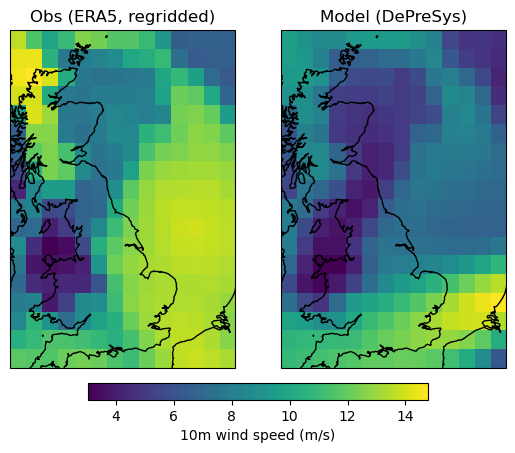

CPU times: user 298 ms, sys: 717 ms, total: 1.02 s
Wall time: 1.83 s


In [11]:
%%time

import cartopy.crs as ccrs

# -------------------------------------------------
# As a test plot the obs and model data
# -------------------------------------------------

# # extract the first value of both to check this has worked
wind_data_obs_box_first_day = wind_data_obs_rg[0, :, :]
model_cube_box_first_day = model_cube_box[0, 0, 0, :, :]

# # Extract the values of both
wind_data_obs_box_first_day_values = wind_data_obs_box_first_day.data
model_cube_box_first_day_values = model_cube_box_first_day.data

# # extract the obs lats
obs_lats = wind_data_obs_box_first_day.coord("latitude").points
obs_lons = wind_data_obs_box_first_day.coord("longitude").points

# # Extract the model lats and lons
model_lats = model_cube_box_first_day.coord("latitude").points
model_lons = model_cube_box_first_day.coord("longitude").points

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the observational data
im0 = axs[0].imshow(
    wind_data_obs_box_first_day_values,
    extent=[obs_lons.min(), obs_lons.max(), obs_lats.min(), obs_lats.max()],
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    origin='upper',
    aspect='auto'
)
axs[0].coastlines()
# Set up theh projection
axs[0].set_title("Obs (ERA5, regridded)")

# Plot the model data
im1 = axs[1].imshow(
    model_cube_box_first_day_values,
    extent=[model_lons.min(), model_lons.max(), model_lats.min(), model_lats.max()],
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    origin='upper',
    aspect='auto'
)
axs[1].coastlines()
axs[1].set_title("Model (DePreSys)")

# Get them to share a horizontal colorbar
cbar = plt.colorbar(im0, ax=axs, orientation="horizontal", fraction=0.046, pad=0.04)
cbar.set_label("10m wind speed (m/s)")

plt.show()

In [12]:
%%time

# -------------------------------------------------
# Load in the model arrays for sfcWind
# -------------------------------------------------

# Loop over and extract the data
years_list = np.arange(1960, 2018 + 1)

# Set up an empty array to append to
model_arr_full = np.zeros((len(years_list), 10, 90, model_cube_box.shape[3], model_cube_box.shape[4]))

model_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/"

# Loop over the years
for i, year in enumerate(range(1960, 2018 + 1)):
    
    # extract the data for this year
    model_arr = np.load(glob.glob(model_dir + f"*sfcWind_UK_{year}_*")[0])
    
    # append to the list
    model_arr_full[i, :, :, :, :] = model_arr

# Print the shape of the model array
print("shape of model array:", model_arr_full.shape)

shape of model array: (59, 10, 90, 18, 14)
CPU times: user 21.4 ms, sys: 49.5 ms, total: 70.9 ms
Wall time: 6 s


In [13]:
%%time

# -------------------------------------------------
# Extract the obs data into an array
# -------------------------------------------------

# Extract the data
obs_arr = wind_data_obs_rg.data

# Print the shape of the obs array
print("shape of obs array:", obs_arr.shape)

# Rename the model array
model_arr = model_arr_full

# Print the shape of the model array
print("shape of model array:", model_arr.shape)

shape of obs array: (5324, 18, 14)
shape of model array: (59, 10, 90, 18, 14)
CPU times: user 1.35 s, sys: 4.29 s, total: 5.65 s
Wall time: 20 s


In [14]:
# -------------------------------------------------
# Extract the observed times to index agains
# -------------------------------------------------

# Extract the obs times
obs_times = wind_data_obs_rg.coord("time").points

# Convert to datetime
obs_times_dt = pd.to_datetime(obs_times, origin="1952-01-01", unit="D")

# Print the obs times dt
print("obs times dt:", obs_times_dt)

obs times dt: DatetimeIndex(['1960-12-01', '1960-12-02', '1960-12-03', '1960-12-04',
               '1960-12-05', '1960-12-06', '1960-12-07', '1960-12-08',
               '1960-12-09', '1960-12-10',
               ...
               '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22',
               '2019-02-23', '2019-02-24', '2019-02-25', '2019-02-26',
               '2019-02-27', '2019-02-28'],
              dtype='datetime64[ns]', length=5324, freq=None)


In [17]:
# -------------------------------------------------
# Extract the model lats and lons
# -------------------------------------------------

# Extract the model lats and lons
model_lats = model_cube_box.coord("latitude").points
model_lons = model_cube_box.coord("longitude").points

In [24]:
# -------------------------------------------------
# Process the block minima for the observations
# -------------------------------------------------

# Set up the years to loop over
years_list = np.arange(1960, 2018 + 1)

# Set up a new array to append to
obs_arr_block_min = np.zeros((np.shape(model_arr)[0], np.shape(obs_arr)[1], np.shape(obs_arr)[2]))

obs_arr_block_min.shape

# Loop over the lats and lons
for lat_idx in tqdm(range(len(model_lats))):
    for lon_idx in range(len(model_lons)):
        # Extract the obs data for this lat and lon
        obs_arr_lat_lon = obs_arr[:, lat_idx, lon_idx]

        # Loop over the years
        for y, year in enumerate(years_list):
            # Find the index of YYYY-12-01
            start_idx = np.where(obs_times_dt == datetime(year, 12, 1))[0][0]

            # Subset the obs times to the month of feb
            obs_times_dt_subset = np.where(
                (obs_times_dt >= datetime(year+1, 1, 1)) & (obs_times_dt <= datetime(year+1, 3, 1)))
            
            # apply these indexes to the obs times
            obs_times_dt_subset_times = obs_times_dt[obs_times_dt_subset]

            # extract the final time
            last_feb_date = obs_times_dt_subset_times[-1]
            
            # Find the index of the last feb date
            end_idx = np.where(obs_times_dt == last_feb_date)[0][0]

            # Extract the obs data for this year
            obs_arr_lat_lon_year = obs_arr_lat_lon[start_idx:end_idx + 1]

            # Find the block minima
            obs_arr_block_min[y, lat_idx, lon_idx] = np.min(obs_arr_lat_lon_year)
        

100%|██████████| 18/18 [00:02<00:00,  8.43it/s]


In [28]:
# -------------------------------------------------
# Process the block minima for the model
# -------------------------------------------------

# Set up the years list
years_list = np.arange(1960, 2018 + 1)

# Set up a new array to append to
model_arr_block_min = np.zeros((np.shape(model_arr)[0], np.shape(model_arr)[1], np.shape(model_arr)[3], np.shape(model_arr)[4]))

# print the shape of this new array
model_arr_block_min.shape

# Set up the n members
n_members = np.shape(model_arr)[1]

# Loop over the lats and lons
for lat_idx in tqdm(range(len(model_lats))):
    for lon_idx in range(len(model_lons)):
        # Extract the model data for this lat and lon
        model_arr_lat_lon = model_arr[:, :, :, lat_idx, lon_idx]

        # Loop over the years
        for y, year in enumerate(years_list):
            # Loop over the members
            for m in range(n_members):
                # Subset the model data for this member
                model_arr_lat_lon_year_member = model_arr[y, m, :, lat_idx, lon_idx]

                # Find the block minima
                model_arr_block_min[y, m, lat_idx, lon_idx] = np.min(model_arr_lat_lon_year_member)

100%|██████████| 18/18 [00:00<00:00, 46.01it/s]


In [35]:
model_arr_block_min.shape

(59, 10, 18, 14)

In [36]:
obs_arr_block_min.shape

(59, 18, 14)

### NO DETRENDING NEEDED BECAUSE WIND SPEED ###

In [80]:
# -------------------------------------------------
# Process the GEVs for all of the grid cells
# -------------------------------------------------

# import gev modules
from scipy.stats import genextreme as gev

# Set up the nboot
nboot = 100

# Set up the shapes for the obs params
obs_params_shape = np.zeros((np.shape(obs_arr_block_min)[1], np.shape(obs_arr_block_min)[2]))

# Set up the shapes for the model params
model_params_shape = np.zeros((nboot, np.shape(model_arr_block_min)[2], np.shape(model_arr_block_min)[3]))

# Set up the GEV params dictionary with separate arrays
gev_params = {
    "obs_shapes": np.zeros_like(obs_params_shape),
    "obs_locs": np.zeros_like(obs_params_shape),
    "obs_scales": np.zeros_like(obs_params_shape),
    "model_shapes": np.zeros_like(model_params_shape),
    "model_locs": np.zeros_like(model_params_shape),
    "model_scales": np.zeros_like(model_params_shape),
}

# Set up the nyears and nmembers
nyears = np.shape(obs_arr_block_min)[0]
nmembers = np.shape(model_arr_block_min)[1]

# Loop over the lats and lons
for lat_idx in tqdm(range(np.shape(obs_arr_block_min)[1])):
    for lon_idx in range(np.shape(obs_arr_block_min)[2]):
        # Extract the obs data for this lat and lon
        obs_arr_lat_lon = obs_arr_block_min[:, lat_idx, lon_idx]

        # Fit the GEV to the obs data
        shape_obs_this, loc_obs_this, scale_obs_this = gev.fit(obs_arr_lat_lon)

        # Store the obs params
        gev_params["obs_shapes"][lat_idx, lon_idx] = shape_obs_this
        gev_params["obs_locs"][lat_idx, lon_idx] = loc_obs_this
        gev_params["obs_scales"][lat_idx, lon_idx] = scale_obs_this

        # Loop over the nboot
        for iboot in range(nboot):
            # if iboot is 100 or a multiple of 100 print the iboot
            if iboot % 100 == 0:
                print(iboot)
            # Set up the pseudo observations
            pseudo_obs_this = np.zeros_like(obs_arr_lat_lon)
            # Loop over the years
            for iyear in range(nyears):
                # Subset the model data for this year
                model_arr_this = model_arr_block_min[iyear, :, lat_idx, lon_idx]

                # Select a random member index
                member_idx = np.random.choice(range(nmembers))

                # Extract the model data for this member
                model_arr_this_member = model_arr_this[member_idx]

                # Add this to the pseudo obs data
                pseudo_obs_this[iyear] = model_arr_this_member

            # Fit the GEV to the pseudo obs data
            shape_model_this, loc_model_this, scale_model_this = gev.fit(pseudo_obs_this)

            # Store the model params
            gev_params["model_shapes"][iboot, lat_idx, lon_idx] = shape_model_this
            gev_params["model_locs"][iboot, lat_idx, lon_idx] = loc_model_this
            gev_params["model_scales"][iboot, lat_idx, lon_idx] = scale_model_this

  0%|          | 0/18 [00:00<?, ?it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


  6%|▌         | 1/18 [00:30<08:40, 30.61s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 11%|█         | 2/18 [01:01<08:15, 30.97s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 17%|█▋        | 3/18 [01:33<07:51, 31.41s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 22%|██▏       | 4/18 [02:05<07:21, 31.52s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 28%|██▊       | 5/18 [02:36<06:48, 31.39s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 33%|███▎      | 6/18 [03:07<06:15, 31.26s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 39%|███▉      | 7/18 [03:38<05:43, 31.24s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 44%|████▍     | 8/18 [04:11<05:15, 31.55s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 50%|█████     | 9/18 [04:42<04:44, 31.64s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 56%|█████▌    | 10/18 [05:14<04:14, 31.75s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 61%|██████    | 11/18 [05:48<03:45, 32.27s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 67%|██████▋   | 12/18 [06:21<03:15, 32.57s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 72%|███████▏  | 13/18 [06:54<02:43, 32.77s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 78%|███████▊  | 14/18 [07:27<02:11, 32.81s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 83%|████████▎ | 15/18 [07:59<01:37, 32.38s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 89%|████████▉ | 16/18 [08:28<01:02, 31.45s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


 94%|█████████▍| 17/18 [08:57<00:30, 30.78s/it]

0
0
0
0
0
0
0
0
0
0
0
0
0
0


100%|██████████| 18/18 [09:26<00:00, 31.50s/it]


In [81]:
gev_params.keys()

dict_keys(['obs_shapes', 'obs_locs', 'obs_scales', 'model_shapes', 'model_locs', 'model_scales'])

In [88]:
# -------------------------------------------------
# Process GEV params into arrays for plotting
# -------------------------------------------------

# Set up an array to store the obs and model params
obs_params_shape = np.zeros((np.shape(obs_arr_block_min)[1], np.shape(obs_arr_block_min)[2]))

# Set up the gev params for the model with separate arrays
gev_params_plotting = {
    "loc": np.zeros_like(obs_params_shape),
    "scale": np.zeros_like(obs_params_shape),
    "shape": np.zeros_like(obs_params_shape),
}

# Set up the lists
obs_moments = ['obs_shapes', 'obs_locs', 'obs_scales']
model_moments = ['model_shapes', 'model_locs', 'model_scales']
plotting_moments = ['shape', 'loc', 'scale']

# iterate over the moments
for obs_moment, model_moment, plotting_moment in zip(obs_moments, model_moments, plotting_moments):
    # print the moments
    print(obs_moment, model_moment, plotting_moment)
    
    for lat_idx in range(np.shape(obs_arr_block_min)[1]):
        for lon_idx in range(np.shape(obs_arr_block_min)[2]):
            # # print the moments
            # print(obs_moment, model_moment, plotting_moment, lat_idx, lon_idx)
            
            # Extract the obs data for this lat and lon
            obs_params_this = gev_params[obs_moment]

            # Extract the model data for this lat and lon
            model_params_this = gev_params[model_moment]

            # Extract the obs params for this lat and lon
            obs_params_this_lat_lon = obs_params_this[lat_idx, lon_idx]

            # Extract the model params for this lat and lon
            model_params_this_lat_lon = model_params_this[:, lat_idx, lon_idx]

            # Calculate the 2.5th percentile of the model params
            model_params_this_lat_lon_025 = np.percentile(model_params_this_lat_lon, 2.5)

            # Calculate the 97.5th percentile of the model params
            model_params_this_lat_lon_975 = np.percentile(model_params_this_lat_lon, 97.5)

            # if the obs params are outside of the model params
            # set a value of 0, otherwise set a value of 1
            if (obs_params_this_lat_lon < model_params_this_lat_lon_025) or (obs_params_this_lat_lon > model_params_this_lat_lon_975):
                gev_params_plotting[plotting_moment][lat_idx, lon_idx] = 0
            else:
                gev_params_plotting[plotting_moment][lat_idx, lon_idx] = 1

    # print the model params this lat lon 025 and 975
    # print("model params this lat lon 025:", model_params_this_lat_lon_025)
    # print("model params this lat lon 975:", model_params_this_lat_lon_975)

obs_shapes model_shapes shape
obs_locs model_locs loc
obs_scales model_scales scale


In [92]:
gev_params_plotting["shape"]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 0

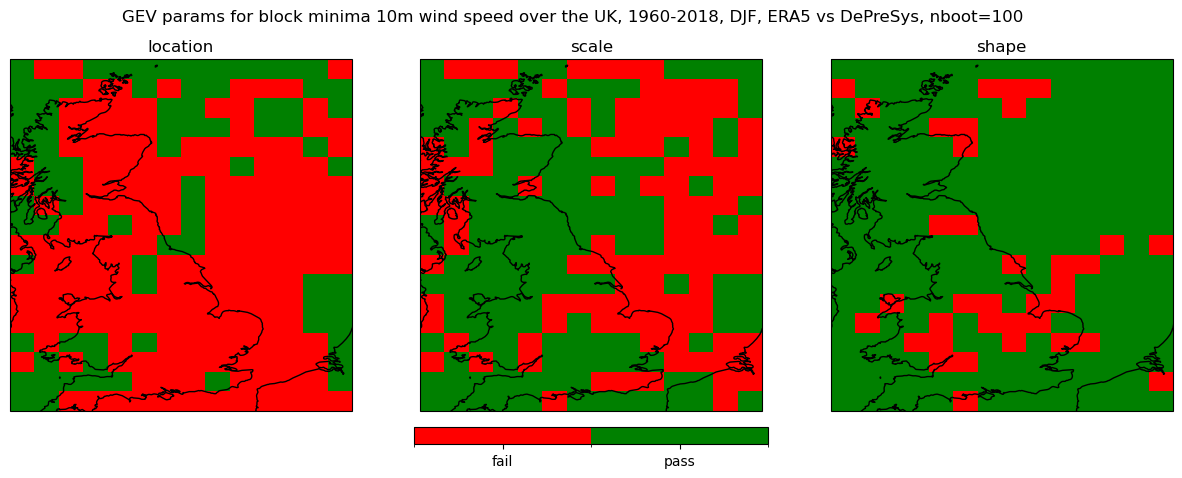

In [97]:
# -------------------------------------------------
# Now we want to plot the results
# -------------------------------------------------

# Import colors
import matplotlib.colors as mcolors

# Set up a figure with three columns and one row
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 5))

# Add the coastlines
for ax in axs:
    ax.coastlines()

# Define the custom colormap
cmap = mcolors.ListedColormap(['red', 'green'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Set up the list of titles
titles = ["location", "scale", "shape"]

# Set up the list of moments
moments = ["loc", "scale", "shape"]

# Loop over the moments
for ax, moment, title in zip(axs, moments, titles):
    # Plot the data
    im = ax.imshow(
        gev_params_plotting[moment],
        cmap=cmap,
        norm=norm,
        extent=[model_lons.min(), model_lons.max(), model_lats.min(), model_lats.max()],
        transform=ccrs.PlateCarree(),
        origin='upper',
        aspect='auto'
    )

    # Set the title
    ax.set_title(title)

# Add a colorbar
cbar = plt.colorbar(im, ax=axs, orientation="horizontal", fraction=0.046, pad=0.04)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["fail", "pass"])

# Set up thye sup title
plt.suptitle("GEV params for block minima 10m wind speed over the UK, 1960-2018, DJF, ERA5 vs DePreSys, nboot=100")

plt.show()

### Now for temperature ###

Do the same, but now for temperature.

In [103]:
# -------------------------------------------------
# First check which files exist before loading model tas data
# -------------------------------------------------

# -------------------------------------------------
# Load in the model arrays for sfcWind
# -------------------------------------------------

# Loop over and extract the data
years_list = np.arange(1960, 2018 + 1)

# Set up an empty array to append to
model_arr_full = np.zeros((len(years_list), 10, 90, model_cube_box.shape[3], model_cube_box.shape[4]))

model_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_arrs/model/"

# Loop over the years
for i, year in enumerate(range(1960, 2018 + 1)):
    
    # find the files
    files = glob.glob(model_dir + f"*tas_UK_{year}_*")

    # if there are no files, print the year
    if len(files) == 0:
        print(year)    

    # extract the data for this year
    model_arr = np.load(files[0])
    
    # append to the list
    model_arr_full[i, :, :, :, :] = model_arr

# Print the shape of the model array
print("shape of model array:", model_arr_full.shape)


shape of model array: (59, 10, 90, 18, 14)


In [104]:
%%time

# -------------------------------------------------
# Load in the observed data
# -------------------------------------------------

obs_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_t2m_daily_1950_2020.nc"

# Load the data with iris
t2m_data_obs = iris.load_cube(obs_path, "t2m")

CPU times: user 21.4 ms, sys: 3.98 ms, total: 25.3 ms
Wall time: 17.9 s


In [106]:
# -------------------------------------------------
# Preprocessing of the obs data
# -------------------------------------------------

# Subset to between 1960 and 2019
t2m_data_obs = t2m_data_obs.extract(iris.Constraint(time=lambda cell: datetime(1960, 12, 1) <= cell.point <= datetime(2019, 3, 1)))

# exrtract only DJF from this
t2m_data_obs = t2m_data_obs.extract(iris.Constraint(time=lambda cell: cell.point.month in [12, 1, 2]))

In [105]:
# -------------------------------------------------
# Load in the model data to regrid obs to
# -------------------------------------------------
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import load_model_data_xarray

model_ds = load_model_data_xarray(
    model_variable="tas",
    model="HadGEM3-GC31-MM",
    experiment="dcppA-hindcast",
    start_year=1960,
    end_year=1960,
    first_fcst_year=1961,
    last_fcst_year=1960 + 10,
    months=[12, 1, 2],
    member="r1i1p1f2",
    frequency="day",
    parallel=False,
)

Model path: /badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast
The model path root is badc
Number of unique variant labels: 10
For model: HadGEM3-GC31-MM
First 10 unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
Number of unique variant labels: 10
Unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
First 10 model files: ['/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_19601101-19601230.nc', '/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_19610101-19611230.nc', '/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r10i1p1f2/day/tas/gn/files/d20200417/tas_d

Processing init years: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


In [107]:
# -------------------------------------------------
# Process the model data into an iris cube
# -------------------------------------------------

# Turn into an iris cube
model_cube = model_ds["tas"].to_iris()

# Intersection to get on the right grid
model_cube = model_cube.intersection(longitude=(-180, 180))

In [108]:
# -------------------------------------------------
# Limit both to the same region
# -------------------------------------------------

# Define the north sea box
uk_n_sea_box = {
    "lat1": 50,
    "lat2": 60,
    "lon1": -7,
    "lon2": 5,
}

# Limit the obs data to the north sea box
t2m_data_obs_box = t2m_data_obs.intersection(
    latitude=(uk_n_sea_box["lat1"], uk_n_sea_box["lat2"]),
    longitude=(uk_n_sea_box["lon1"], uk_n_sea_box["lon2"]),
)

# # limit the model data to the north sea box
model_cube_box = model_cube.intersection(
    latitude=(uk_n_sea_box["lat1"], uk_n_sea_box["lat2"]),
    longitude=(uk_n_sea_box["lon1"], uk_n_sea_box["lon2"]),
)

In [109]:
# -------------------------------------------------
# Regrid the obs data to the model data
# -------------------------------------------------

# Regrid the obs data to the model data
t2m_data_obs_rg = t2m_data_obs_box.regrid(model_cube_box, iris.analysis.Linear())

In [110]:
%%time

# -------------------------------------------------
# Extract the obs data into an array
# -------------------------------------------------

# Extract the data
obs_arr = t2m_data_obs_rg.data

# Print the shape of the obs array
print("shape of obs array:", obs_arr.shape)

# Rename the model array
model_arr = model_arr_full

# Print the shape of the model array
print("shape of model array:", model_arr.shape)